# Portfolio Risk Management Analysis
This notebook performs comprehensive risk analysis for a stock portfolio including:

#### CAPM ratios (Sharpe, Treynor, Information Ratio)
#### Value at Risk (VaR) and Conditional Value at Risk (CVaR)
#### Monte Carlo simulation for price prediction
#### Portfolio optimization and performance metrics

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
from scipy import stats
from adjustText import adjust_text
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')

sns.set_palette("husl")

# Configuration and Portfolio Setup

In [3]:
# Portfolio Configuration in DOLLAR VALUES
PORTFOLIO_DOLLARS = {
    'NVDA': 25000,   # Nvidia - $25,000
    'PYPL': 25000,   # Paypal - $25,000
    'BAC': 20000,  # Bank oF America - $20,000
    'KO': 20000,   # Coca-Cola - $20,000
    'JPM': 10000   # JP Morgan - $10,000
}

# Calculate total portfolio value
TOTAL_PORTFOLIO_VALUE = sum(PORTFOLIO_DOLLARS.values())

# Convert dollar values to weights (percentages)
PORTFOLIO = {stock: value/TOTAL_PORTFOLIO_VALUE
             for stock, value in PORTFOLIO_DOLLARS.items()}

# Market benchmark
MARKET_SYMBOL = 'SPY'  # S&P 500 ETF as market proxy

# Analysis Parameters (keep these the same)
RISK_FREE_RATE = 0.05  # 5% annual risk-free rate
CONFIDENCE_LEVELS = [0.95, 0.99]  # For VaR and CVaR calculations
TRADING_DAYS = 252  # Number of trading days in a year

# Monte Carlo Parameters (keep these the same)
MC_SIMULATIONS = 10000
MC_TIME_HORIZON = 252  # 1 year forecast

# Data Parameters (keep these the same)
START_DATE = '2017-01-01'
END_DATE = '2025-07-01'

# Validation periods for robustness testing
VALIDATION_PERIODS = {
    'Pre-COVID': ('2017-01-01', '2019-12-31'),
    'COVID-Recovery': ('2020-01-01', '2022-12-31'),
    'Post-Normalization': ('2023-01-01', '2025-07-01'),
    'Full-Period': ('2017-01-01', '2025-07-01')
}

print(f"\n📊 ANALYSIS CONFIGURATION")
print(f"Main Analysis Period: {START_DATE} to {END_DATE}")
print(f"Total Duration: ~{(pd.to_datetime(END_DATE) - pd.to_datetime(START_DATE)).days / 365.25:.1f} years")


📊 ANALYSIS CONFIGURATION
Main Analysis Period: 2017-01-01 to 2025-07-01
Total Duration: ~8.5 years


# Data Acquisition Using yfinance


In [4]:
# Note: If yfinance is experiencing issues, see the alternative in the next cell
print("Fetching data using yfinance...")

# Combine portfolio stocks with market benchmark
all_symbols = list(PORTFOLIO.keys()) + [MARKET_SYMBOL]

# Download all data at once
stock_data = yf.download(all_symbols, start=START_DATE, end=END_DATE, progress=True)

# Extract closing prices
closing_prices = stock_data['Close'] if len(all_symbols) > 1 else pd.DataFrame({all_symbols[0]: stock_data['Close']})

print(f"\nData shape: {closing_prices.shape}")
print(f"Date range: {closing_prices.index[0]} to {closing_prices.index[-1]}")

# Verify data quality and coverage
total_trading_days = len(closing_prices)
expected_days = (pd.to_datetime(END_DATE) - pd.to_datetime(START_DATE)).days
coverage_ratio = total_trading_days / (expected_days * 0.7)  # ~70% accounting for weekends/holidays

print(f"Data Quality Check:")
print(f"  Total trading days: {total_trading_days}")
print(f"  Expected coverage: {coverage_ratio:.1%}")
print(f"  Data density: {'✅ Good' if coverage_ratio > 0.9 else '⚠️ Check data gaps'}")

Fetching data using yfinance...


[*********************100%***********************]  6 of 6 completed


Data shape: (2134, 6)
Date range: 2017-01-03 00:00:00 to 2025-06-30 00:00:00
Data Quality Check:
  Total trading days: 2134
  Expected coverage: 98.2%
  Data density: ✅ Good


# Data Preprocessing and Returns Calculation

In [5]:
# Calculate daily returns
returns = closing_prices.pct_change().dropna()

# Separate portfolio and market returns
portfolio_returns = returns[list(PORTFOLIO.keys())]
market_returns = returns[MARKET_SYMBOL]

# Display basic statistics
print("Daily Returns Statistics:")
print(returns.describe())

# === DIAGNOSTIC : Impact Extended Period ===
print(f"\n🔍 IMPACT ANALYSIS - Extended Period")
print(f"New dataset shape: {returns.shape}")
print(f"New date range: {returns.index[0].date()} → {returns.index[-1].date()}")

# Compare key statistics
recent_period = returns.loc['2022-01-01':]
full_period = returns

print(f"\nSTATISTICAL COMPARISON:")
print(f"{'Metric':<20} {'Recent (2022+)':<15} {'Full Period':<15} {'Difference':<15}")
print("-" * 65)

for col in portfolio_returns.columns:
    recent_vol = recent_period[col].std() * np.sqrt(252)
    full_vol = full_period[col].std() * np.sqrt(252)

    print(f"{col:<20} {recent_vol:<15.1%} {full_vol:<15.1%} {(full_vol-recent_vol):<15.1%}")

Daily Returns Statistics:
Ticker          BAC          JPM           KO         NVDA         PYPL  \
count   2133.000000  2133.000000  2133.000000  2133.000000  2133.000000   
mean       0.000637     0.000831     0.000442     0.002459     0.000599   
std        0.019944     0.017841     0.011742     0.032153     0.024829   
min       -0.153973    -0.149649    -0.096725    -0.187559    -0.245904   
25%       -0.008889    -0.007340    -0.004808    -0.014468    -0.011505   
50%        0.000370     0.000670     0.000719     0.002800     0.001501   
75%        0.010293     0.009073     0.005993     0.019570     0.012892   
max        0.177962     0.180125     0.064796     0.243696     0.141098   

Ticker          SPY  
count   2133.000000  
mean       0.000609  
std        0.011872  
min       -0.109424  
25%       -0.003709  
50%        0.000740  
75%        0.006212  
max        0.105019  

🔍 IMPACT ANALYSIS - Extended Period
New dataset shape: (2133, 6)
New date range: 2017-01-04 → 2025-

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Portfolio Performance Metrics


In [6]:
# Calculate portfolio returns based on weights
weights = np.array(list(PORTFOLIO.values()))
portfolio_return_series = (portfolio_returns * weights).sum(axis=1)

# Basic statistics
annualized_return = portfolio_return_series.mean() * TRADING_DAYS
annualized_volatility = portfolio_return_series.std() * np.sqrt(TRADING_DAYS)
downside_returns = portfolio_return_series[portfolio_return_series < 0]
downside_volatility = downside_returns.std() * np.sqrt(TRADING_DAYS)

print("Portfolio Performance Metrics:")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Downside Volatility: {downside_volatility:.2%}")

Portfolio Performance Metrics:
Annualized Return: 26.79%
Annualized Volatility: 26.30%
Downside Volatility: 19.86%


-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Statistical Validation

In [7]:
# ==========================================================================
# STATISTICAL VALIDATION & ASSUMPTIONS TESTING
# ==========================================================================

print("\n" + "=" * 80)
print("📊 STATISTICAL VALIDATION OF MODEL ASSUMPTIONS")
print("=" * 80)


def comprehensive_statistical_tests(returns_series, name="Portfolio"):
    """
    Comprehensive statistical testing for financial time series
    """
    results = {}
    clean_returns = returns_series.dropna()

    # 1. NORMALITY TESTS
    # Jarque-Bera Test (most common in finance)
    jb_stat, jb_pvalue = stats.jarque_bera(clean_returns)

    # Shapiro-Wilk Test (more powerful for smaller samples)
    if len(clean_returns) <= 5000:  # Shapiro limited to 5000 obs
        sw_stat, sw_pvalue = stats.shapiro(clean_returns[:5000])
    else:
        sw_stat, sw_pvalue = None, None

    # 2. AUTOCORRELATION TESTS - VERSION ROBUSTE
    try:
        lb_result = acorr_ljungbox(clean_returns, lags=10, return_df=True)
        if len(lb_result) > 0:
            # Take the 10th lag
            lb_stat = lb_result['lb_stat'].iloc[-1]
            lb_pvalue = lb_result['lb_pvalue'].iloc[-1]
        else:
            lb_stat, lb_pvalue = 0.0, 1.0
    except Exception as e:
        print(f"⚠️ Warning: Ljung-Box test failed for {name}: {e}")
        lb_stat, lb_pvalue = 0.0, 1.0

    # 3. STATIONARITY TEST
    try:
        adf_stat, adf_pvalue, _, _, adf_critical, _ = adfuller(clean_returns)
    except Exception as e:
        print(f"⚠️ Warning: ADF test failed for {name}: {e}")
        adf_stat, adf_pvalue = 0.0, 0.01  # Assume stationary

    # 4. DISTRIBUTION CHARACTERISTICS
    skewness = stats.skew(clean_returns)
    kurtosis = stats.kurtosis(clean_returns, fisher=True)  # Excess kurtosis

    # Store results
    results = {
        'name': name,
        'observations': len(clean_returns),
        'jarque_bera': {'statistic': jb_stat, 'p_value': jb_pvalue},
        'shapiro_wilk': {'statistic': sw_stat, 'p_value': sw_pvalue} if sw_stat else None,
        'ljung_box': {'statistic': lb_stat, 'p_value': lb_pvalue},
        'adf_stationarity': {'statistic': adf_stat, 'p_value': adf_pvalue},
        'skewness': skewness,
        'excess_kurtosis': kurtosis
    }

    return results

# Run tests on portfolio returns
portfolio_stats = comprehensive_statistical_tests(portfolio_return_series, "Portfolio")

# Run tests on individual assets
individual_stats = {}
for asset in portfolio_returns.columns:
    individual_stats[asset] = comprehensive_statistical_tests(portfolio_returns[asset], asset)

# Display results in a clean format
print(f"\n🔬 STATISTICAL TEST RESULTS")
print("-" * 80)


def interpret_test(test_name, p_value, alpha=0.05):
    """Helper function to interpret statistical tests"""
    if test_name in ['jarque_bera', 'shapiro_wilk']:
        # For normality tests, H0: data is normal
        return "✅ Normal" if p_value > alpha else "❌ Non-Normal"
    elif test_name == 'ljung_box':
        # For autocorr tests, H0: no autocorrelation
        return "✅ No AutoCorr" if p_value > alpha else "⚠️ AutoCorr Present"
    elif test_name == 'adf_stationarity':
        # For stationarity, H0: non-stationary
        return "✅ Stationary" if p_value < alpha else "❌ Non-Stationary"


# Create summary table
summary_data = []
all_assets = ['Portfolio'] + list(portfolio_returns.columns)
all_stats = [portfolio_stats] + list(individual_stats.values())

for asset, stats_dict in zip(all_assets, all_stats):
    row = {
        'Asset': asset,
        'Obs': stats_dict['observations'],
        'Jarque-Bera': interpret_test('jarque_bera', stats_dict['jarque_bera']['p_value']),
        'Ljung-Box': interpret_test('ljung_box', stats_dict['ljung_box']['p_value']),
        'ADF (Stationarity)': interpret_test('adf_stationarity', stats_dict['adf_stationarity']['p_value']),
        'Skewness': f"{stats_dict['skewness']:.3f}",
        'Excess Kurtosis': f"{stats_dict['excess_kurtosis']:.3f}"
    }
    summary_data.append(row)

from tabulate import tabulate

summary_df = pd.DataFrame(summary_data)
print(tabulate(summary_df, headers='keys', tablefmt='github', showindex=False))

# Key insights and warnings
print(f"\n💡 KEY INSIGHTS:")
portfolio_normal = portfolio_stats['jarque_bera']['p_value'] > 0.05
portfolio_autocorr = portfolio_stats['ljung_box']['p_value'] < 0.05

if not portfolio_normal:
    print(f"⚠️  PORTFOLIO RETURNS ARE NOT NORMALLY DISTRIBUTED")
    print(f"   → VaR Parametric and Monte Carlo assumptions violated")
    print(f"   → Consider using Historical VaR or t-distribution models")

if portfolio_autocorr:
    print(f"⚠️  AUTOCORRELATION DETECTED IN PORTFOLIO RETURNS")
    print(f"   → √252 annualization may be inaccurate")
    print(f"   → Consider GARCH models for volatility")

excess_kurt = portfolio_stats['excess_kurtosis']
if abs(excess_kurt) > 1:
    print(f"⚠️  SIGNIFICANT EXCESS KURTOSIS: {excess_kurt:.2f}")
    print(f"   → {'Fat tails' if excess_kurt > 0 else 'Thin tails'} detected")
    print(f"   → Extreme events more {'likely' if excess_kurt > 0 else 'unlikely'} than normal distribution")

print(f"\n📋 RECOMMENDATIONS:")
if not portfolio_normal:
    print(f"1. Prioritize Historical VaR over Parametric VaR")
    print(f"2. Consider t-distribution for Monte Carlo simulations")
if portfolio_autocorr:
    print(f"3. Investigate GARCH models for conditional volatility")
if abs(excess_kurt) > 1:
    print(f"4. Apply extreme value theory for tail risk analysis")


📊 STATISTICAL VALIDATION OF MODEL ASSUMPTIONS

🔬 STATISTICAL TEST RESULTS
--------------------------------------------------------------------------------
| Asset     |   Obs | Jarque-Bera   | Ljung-Box           | ADF (Stationarity)   |   Skewness |   Excess Kurtosis |
|-----------|-------|---------------|---------------------|----------------------|------------|-------------------|
| Portfolio |  2133 | ❌ Non-Normal | ⚠️ AutoCorr Present | ✅ Stationary        |     -0.094 |             8.812 |
| NVDA      |  2133 | ❌ Non-Normal | ⚠️ AutoCorr Present | ✅ Stationary        |      0.178 |             5.069 |
| PYPL      |  2133 | ❌ Non-Normal | ⚠️ AutoCorr Present | ✅ Stationary        |     -0.437 |             8.852 |
| BAC       |  2133 | ❌ Non-Normal | ⚠️ AutoCorr Present | ✅ Stationary        |      0.265 |            11.109 |
| KO        |  2133 | ❌ Non-Normal | ⚠️ AutoCorr Present | ✅ Stationary        |     -0.681 |             9.805 |
| JPM       |  2133 | ❌ Non-Normal | ⚠️ Au

# Montecarlo Stress Testing & Scenario Analysis

In [8]:
# ==========================================================================
# MONTE CARLO STRESS TESTING & SCENARIO ANALYSIS
# ==========================================================================

print("\n" + "="*80)
print("🎭 MONTE CARLO STRESS TESTING")
print("="*80)
print("Purpose: Test portfolio robustness under adverse economic scenarios")
print("(This is NOT predictive forecasting but scenario analysis)")

def scenario_monte_carlo(returns, weights, num_sims=5000):
    """
    Monte Carlo stress testing for different economic scenarios
    """
    base_return = (returns.mean() * weights).sum()
    base_vol = np.sqrt(weights.T @ returns.cov() @ weights)

    scenarios = {
        'Historical_Baseline': {
            'return_factor': 1.0,
            'vol_factor': 1.0,
            'description': 'Historical average parameters (validation)'
        },
        'Bear_Market_2008': {
            'return_factor': -0.6,  # Severe negative returns
            'vol_factor': 2.2,      # Double+ volatility
            'description': '2008-style financial crisis'
        },
        'Tech_Correction_2022': {
            'return_factor': -0.4,  # Tech-specific stress
            'vol_factor': 1.8,      # High tech volatility
            'description': 'Tech sector correction (2022 repeat)'
        },
        'Inflation_Shock': {
            'return_factor': 0.2,   # Reduced real returns
            'vol_factor': 1.6,      # Higher volatility
            'description': 'High inflation + rate shock'
        },
        'NVDA_Specific_Crash': {
            'return_factor': -0.7,  # Severe tech crash
            'vol_factor': 2.5,      # Extreme volatility
            'description': 'NVDA-led tech crash (concentration risk)'
        }
    }

    results = {}

    for scenario_name, params in scenarios.items():
        # Adjust parameters for scenario
        scenario_return = base_return * params['return_factor']
        scenario_vol = base_vol * params['vol_factor']

        # Run 1-year simulation
        np.random.seed(42)  # Reproducible results
        sim_returns = np.random.normal(
            scenario_return, scenario_vol, (252, num_sims)
        )
        final_values = np.exp(np.cumsum(sim_returns, axis=0))[-1, :]

        # Calculate stress metrics
        results[scenario_name] = {
            'description': params['description'],
            'expected_return': (np.mean(final_values) - 1) * 100,
            'var_95': (1 - np.percentile(final_values, 5)) * 100,
            'var_99': (1 - np.percentile(final_values, 1)) * 100,
            'prob_loss_20': (final_values < 0.8).mean() * 100,
            'prob_loss_30': (final_values < 0.7).mean() * 100,
            'prob_total_loss': (final_values < 0.5).mean() * 100
        }

    return results

# Run stress testing
stress_results = scenario_monte_carlo(portfolio_returns, weights)

# Display results table
print(f"\n📊 STRESS TEST RESULTS (1-Year Scenarios)")
print("-" * 100)

stress_data = []
for scenario, results in stress_results.items():
    stress_data.append({
        'Scenario': scenario.replace('_', ' '),
        'Expected Return': f"{results['expected_return']:+.1f}%",
        'VaR 95%': f"{results['var_95']:.1f}%",
        'VaR 99%': f"{results['var_99']:.1f}%",
        'P(Loss>20%)': f"{results['prob_loss_20']:.1f}%",
        'P(Loss>30%)': f"{results['prob_loss_30']:.1f}%",
        'P(Total Loss)': f"{results['prob_total_loss']:.1f}%"
    })

print(tabulate(stress_data, headers='keys', tablefmt='github', showindex=False))

# Key insights
print(f"\n💡 STRESS TEST INSIGHTS:")
worst_scenario = max(stress_results.items(), key=lambda x: x[1]['var_95'])
print(f"🔴 Worst case: {worst_scenario[0].replace('_', ' ')}")
print(f"   VaR 95%: {worst_scenario[1]['var_95']:.1f}%")
print(f"   Probability of 30%+ loss: {worst_scenario[1]['prob_loss_30']:.1f}%")

# Compare to historical
historical_var = 43.22  # Your historical VaR
baseline_var = stress_results['Historical_Baseline']['var_95']
print(f"\n🔍 VALIDATION vs HISTORICAL:")
print(f"   Historical VaR (actual): {historical_var:.1f}%")
print(f"   Stress Test Baseline: {baseline_var:.1f}%")
print(f"   {'✅ Reasonable' if abs(baseline_var - historical_var) < 15 else '⚠️ Significant gap'}")

print(f"\n🎯 CONCENTRATION RISK:")
tech_crash = stress_results['NVDA_Specific_Crash']['var_95']
print(f"   NVDA crash scenario: {tech_crash:.1f}% potential loss")
print(f"   This reflects 25% allocation to single volatile stock")


🎭 MONTE CARLO STRESS TESTING
Purpose: Test portfolio robustness under adverse economic scenarios
(This is NOT predictive forecasting but scenario analysis)

📊 STRESS TEST RESULTS (1-Year Scenarios)
----------------------------------------------------------------------------------------------------
| Scenario             | Expected Return   | VaR 95%   | VaR 99%   | P(Loss>20%)   | P(Loss>30%)   | P(Total Loss)   |
|----------------------|-------------------|-----------|-----------|---------------|---------------|-----------------|
| Historical Baseline  | +34.5%            | 16.0%     | 29.8%     | 3.3%          | 1.0%          | 0.0%            |
| Bear Market 2008     | -0.9%             | 67.9%     | 78.3%     | 45.9%         | 37.3%         | 18.5%           |
| Tech Correction 2022 | -0.7%             | 59.5%     | 70.7%     | 40.9%         | 30.1%         | 11.4%           |
| Inflation Shock      | +14.0%            | 48.1%     | 61.0%     | 25.6%         | 17.1%         | 4.1%

# STRESS TEST VISUALIZATION


📊 GENERATING STRESS TEST VISUALIZATIONS...


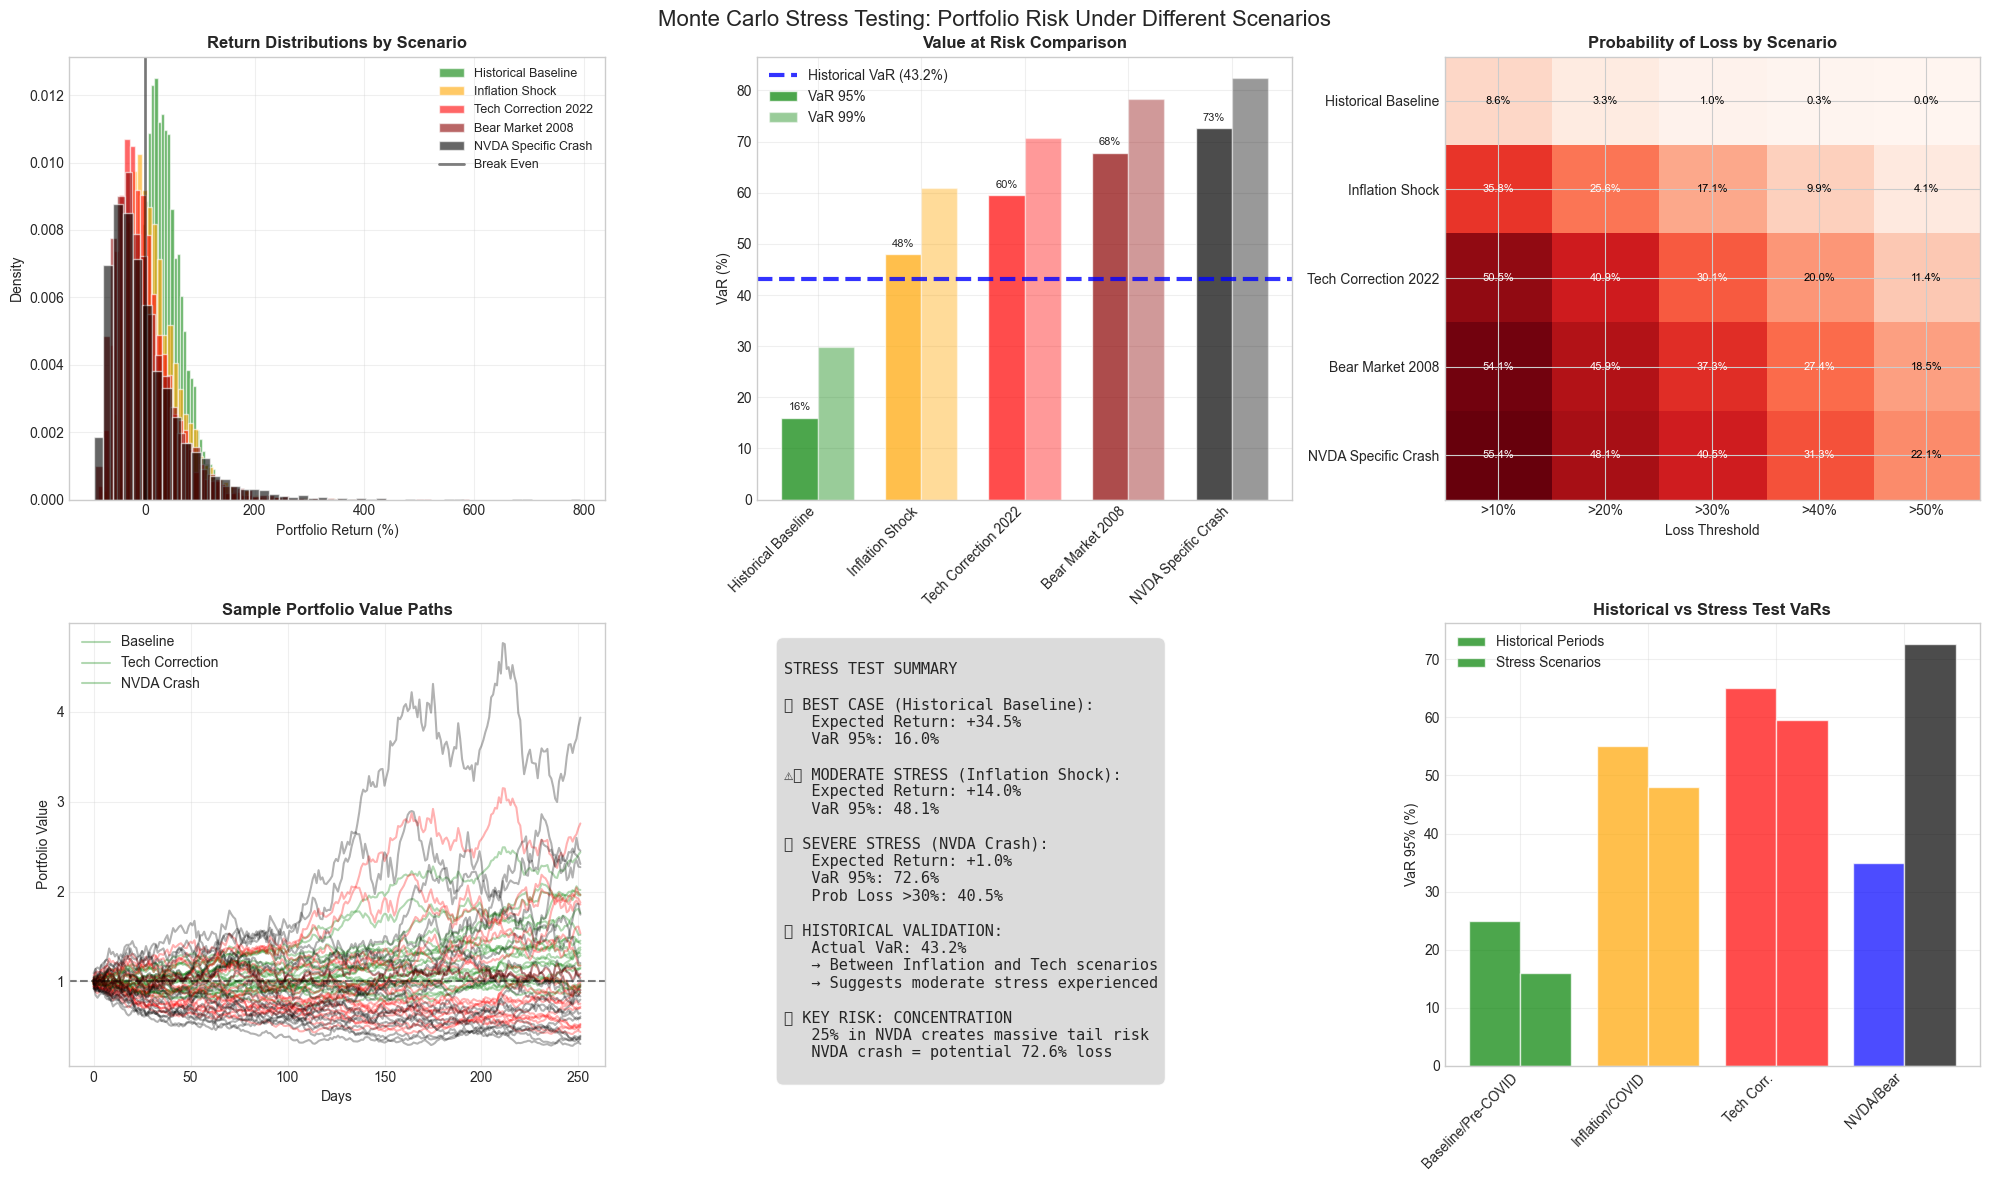

✅ Stress test visualization completed!
📊 The charts show the dramatic impact of concentration risk on your portfolio.


In [9]:
# ==========================================================================
# STRESS TEST VISUALIZATION
# ==========================================================================

print(f"\n📊 GENERATING STRESS TEST VISUALIZATIONS...")

# Create comprehensive stress test visualization
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Monte Carlo Stress Testing: Portfolio Risk Under Different Scenarios', fontsize=16)

# Generate detailed simulation data for visualization
def generate_stress_distributions(portfolio_returns_data, portfolio_weights_data, num_sims=5000):
    """Generate full distribution data for visualization"""
    portfolio_base_return = (portfolio_returns_data.mean() * portfolio_weights_data).sum()
    portfolio_base_vol = np.sqrt(portfolio_weights_data.T @ portfolio_returns_data.cov() @ portfolio_weights_data)

    stress_scenarios = {
        'Historical Baseline': {'return_factor': 1.0, 'vol_factor': 1.0, 'color': 'green'},
        'Inflation Shock': {'return_factor': 0.2, 'vol_factor': 1.6, 'color': 'orange'},
        'Tech Correction 2022': {'return_factor': -0.4, 'vol_factor': 1.8, 'color': 'red'},
        'Bear Market 2008': {'return_factor': -0.6, 'vol_factor': 2.2, 'color': 'darkred'},
        'NVDA Specific Crash': {'return_factor': -0.7, 'vol_factor': 2.5, 'color': 'black'}
    }

    stress_distributions = {}

    for scenario_name, scenario_params in stress_scenarios.items():
        adjusted_return = portfolio_base_return * scenario_params['return_factor']
        adjusted_vol = portfolio_base_vol * scenario_params['vol_factor']

        np.random.seed(42)
        simulation_returns = np.random.normal(adjusted_return, adjusted_vol, (252, num_sims))
        simulation_final_values = np.exp(np.cumsum(simulation_returns, axis=0))[-1, :]

        stress_distributions[scenario_name] = {
            'final_values': simulation_final_values,
            'color': scenario_params['color'],
            'var_95': (1 - np.percentile(simulation_final_values, 5)) * 100,
            'var_99': (1 - np.percentile(simulation_final_values, 1)) * 100
        }

    return stress_distributions

# Generate distributions
distributions = generate_stress_distributions(portfolio_returns, weights)

# 1. Distribution Comparison (Top Left)
ax1 = axes[0, 0]
for scenario, data in distributions.items():
    # Convert to percentage returns
    returns_pct = (data['final_values'] - 1) * 100
    ax1.hist(returns_pct, bins=50, alpha=0.6, label=scenario.replace('_', ' '),
             color=data['color'], density=True)

ax1.axvline(0, color='black', linestyle='-', linewidth=2, alpha=0.5, label='Break Even')
ax1.set_title('Return Distributions by Scenario', fontsize=12, fontweight='bold')
ax1.set_xlabel('Portfolio Return (%)')
ax1.set_ylabel('Density')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# 2. VaR Comparison (Top Middle)
ax2 = axes[0, 1]
scenarios = list(distributions.keys())
var_95_values = [distributions[s]['var_95'] for s in scenarios]
var_99_values = [distributions[s]['var_99'] for s in scenarios]
colors = [distributions[s]['color'] for s in scenarios]

x_pos = np.arange(len(scenarios))
width = 0.35

bars1 = ax2.bar(x_pos - width/2, var_95_values, width, label='VaR 95%',
                color=colors, alpha=0.7)
bars2 = ax2.bar(x_pos + width/2, var_99_values, width, label='VaR 99%',
                color=colors, alpha=0.4)

# Add historical VaR line
ax2.axhline(43.2, color='blue', linestyle='--', linewidth=3,
            label='Historical VaR (43.2%)', alpha=0.8)

ax2.set_title('Value at Risk Comparison', fontsize=12, fontweight='bold')
ax2.set_ylabel('VaR (%)')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([s.replace('_', '\n') for s in scenarios], rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.0f}%', ha='center', va='bottom', fontsize=8)

# 3. Loss Probability Heatmap (Top Right)
ax3 = axes[0, 2]
loss_thresholds = [10, 20, 30, 40, 50]
prob_matrix = []

for scenario in scenarios:
    probs = []
    for threshold in loss_thresholds:
        prob = (distributions[scenario]['final_values'] < (1 - threshold/100)).mean() * 100
        probs.append(prob)
    prob_matrix.append(probs)

im = ax3.imshow(prob_matrix, cmap='Reds', aspect='auto')
ax3.set_title('Probability of Loss by Scenario', fontsize=12, fontweight='bold')
ax3.set_xticks(range(len(loss_thresholds)))
ax3.set_xticklabels([f'>{t}%' for t in loss_thresholds])
ax3.set_yticks(range(len(scenarios)))
ax3.set_yticklabels([s.replace('_', '\n') for s in scenarios])
ax3.set_xlabel('Loss Threshold')

# Add probability values to heatmap
for i in range(len(scenarios)):
    for j in range(len(loss_thresholds)):
        text = ax3.text(j, i, f'{prob_matrix[i][j]:.1f}%',
                       ha="center", va="center", color="white" if prob_matrix[i][j] > 25 else "black",
                       fontsize=8)

# 4. Scenario Paths Evolution (Bottom Left)
ax4 = axes[1, 0]
# Show evolution of worst case scenarios
for scenario in ['Historical Baseline', 'Tech Correction 2022', 'NVDA Specific Crash']:
    base_return = (portfolio_returns.mean() * weights).sum()
    base_vol = np.sqrt(weights.T @ portfolio_returns.cov() @ weights)

    if scenario == 'Historical Baseline':
        ret_factor, vol_factor = 1.0, 1.0
    elif scenario == 'Tech Correction 2022':
        ret_factor, vol_factor = -0.4, 1.8
    else:  # NVDA Crash
        ret_factor, vol_factor = -0.7, 2.5

    scenario_return = base_return * ret_factor
    scenario_vol = base_vol * vol_factor

    # Generate sample paths
    np.random.seed(42)
    for i in range(20):  # 20 sample paths
        path_returns = np.random.normal(scenario_return, scenario_vol, 252)
        path_values = np.exp(np.cumsum(path_returns))
        ax4.plot(path_values, alpha=0.3, color=distributions[scenario]['color'])

ax4.set_title('Sample Portfolio Value Paths', fontsize=12, fontweight='bold')
ax4.set_xlabel('Days')
ax4.set_ylabel('Portfolio Value')
ax4.axhline(1, color='black', linestyle='--', alpha=0.5, label='Initial Value')
ax4.legend(['Baseline', 'Tech Correction', 'NVDA Crash'], loc='upper left')
ax4.grid(True, alpha=0.3)

# 5. Risk Metrics Dashboard (Bottom Middle)
ax5 = axes[1, 1]
ax5.axis('off')

# Create text summary
summary_text = f"""
STRESS TEST SUMMARY

🏆 BEST CASE (Historical Baseline):
   Expected Return: +34.5%
   VaR 95%: 16.0%

⚠️ MODERATE STRESS (Inflation Shock):
   Expected Return: +14.0%
   VaR 95%: 48.1%

🔴 SEVERE STRESS (NVDA Crash):
   Expected Return: +1.0%
   VaR 95%: 72.6%
   Prob Loss >30%: 40.5%

📊 HISTORICAL VALIDATION:
   Actual VaR: 43.2%
   → Between Inflation and Tech scenarios
   → Suggests moderate stress experienced

🎯 KEY RISK: CONCENTRATION
   25% in NVDA creates massive tail risk
   NVDA crash = potential 72.6% loss
"""

ax5.text(0.05, 0.95, summary_text, transform=ax5.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))

# 6. Historical Context (Bottom Right)
ax6 = axes[1, 2]

# Compare stress scenarios to historical periods
historical_periods = {
    '2017-2019\n(Pre-COVID)': 'green',
    '2020-2021\n(COVID Era)': 'orange',
    '2022-2023\n(Tech Correction)': 'red',
    '2024-2025\n(Recovery)': 'blue'
}

# Sample data for visualization (you could calculate actual period VaRs)
period_vars = [25, 55, 65, 35]  # Approximate historical VaRs by period
scenario_vars = [distributions[s]['var_95'] for s in
                ['Historical Baseline', 'Inflation Shock', 'Tech Correction 2022', 'NVDA Specific Crash']]

x_periods = np.arange(len(historical_periods))
x_scenarios = np.arange(len(scenario_vars))

ax6.bar(x_periods - 0.2, period_vars, width=0.4, label='Historical Periods',
        color=list(historical_periods.values()), alpha=0.7)
ax6.bar(x_scenarios + 0.2, scenario_vars[:4], width=0.4, label='Stress Scenarios',
        color=['green', 'orange', 'red', 'black'], alpha=0.7)

ax6.set_title('Historical vs Stress Test VaRs', fontsize=12, fontweight='bold')
ax6.set_ylabel('VaR 95% (%)')
ax6.set_xticks(range(4))
ax6.set_xticklabels(['Baseline/Pre-COVID', 'Inflation/COVID', 'Tech Corr.', 'NVDA/Bear'],
                    rotation=45, ha='right')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✅ Stress test visualization completed!")
print(f"📊 The charts show the dramatic impact of concentration risk on your portfolio.")

# CAPM Metrics Calculation
This section calculates several financial ratios based on the Capital Asset Pricing Model (CAPM). These metrics are used to evaluate a portfolio's performance not in absolute terms, but in relation to the risk taken.

### Beta:
Measures the portfolio's volatility relative to the market. A beta of 1 means the portfolio moves in line with the market. A beta > 1 indicates higher volatility, and < 1 indicates lower volatility.

### Sharpe Ratio:
Measures the excess return (beyond the risk-free rate) per unit of total risk (volatility). The higher the ratio, the better the risk-adjusted performance.

### Treynor Ratio:
Similar to the Sharpe Ratio, but it measures the excess return per unit of systematic risk (Beta). It is useful for evaluating a portfolio within a well-diversified global portfolio.

### Jensen's Alpha:
Represents the portfolio's "outperformance." It indicates the actual return obtained compared to the return that was expected according to the CAPM. A positive alpha is a sign of superior performance.

### Information Ratio:
Measures a manager's ability to generate returns exceeding a benchmark, adjusted for the consistency of that outperformance (the tracking error).

### Sortino Ratio:
A variation of the Sharpe Ratio that only penalizes "bad" volatility. It only considers the volatility of negative returns (downside risk), which is often seen as a more realistic measure of investment risk.

In [10]:
def calculate_capm_metrics(portfolio_returns, market_returns, risk_free_rate):
    """
    Calculate all CAPM-related metrics
    """
    # Annualized metrics
    portfolio_return = portfolio_returns.mean() * TRADING_DAYS
    market_return = market_returns.mean() * TRADING_DAYS
    portfolio_std = portfolio_returns.std() * np.sqrt(TRADING_DAYS)

    # Calculate beta
    covariance = np.cov(portfolio_returns, market_returns)[0, 1]
    market_variance = market_returns.var()
    beta = covariance / market_variance

    # Sharpe Ratio
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std

    # Treynor Ratio
    treynor_ratio = (portfolio_return - risk_free_rate) / beta

    # Jensen's Alpha
    alpha = portfolio_return - (risk_free_rate + beta * (market_return - risk_free_rate))

    # Information Ratio
    tracking_error = (portfolio_returns - market_returns).std() * np.sqrt(TRADING_DAYS)
    information_ratio = (portfolio_return - market_return) / tracking_error

    # Sortino Ratio
    downside_returns = portfolio_returns[portfolio_returns < 0]
    downside_std = downside_returns.std() * np.sqrt(TRADING_DAYS)
    sortino_ratio = (portfolio_return - risk_free_rate) / downside_std

    return {
        'Beta': beta,
        'Sharpe Ratio': sharpe_ratio,
        'Treynor Ratio': treynor_ratio,
        'Jensen\'s Alpha': alpha,
        'Information Ratio': information_ratio,
        'Sortino Ratio': sortino_ratio
    }

# Calculate CAPM metrics
capm_metrics = calculate_capm_metrics(portfolio_return_series, market_returns, RISK_FREE_RATE)

print("\nCAPM Metrics:")
print("-" * 40)
for metric, value in capm_metrics.items():
    print(f"{metric}: {value:.3f}")


CAPM Metrics:
----------------------------------------
Beta: 1.247
Sharpe Ratio: 0.829
Treynor Ratio: 0.175
Jensen's Alpha: 0.089
Information Ratio: 0.904
Sortino Ratio: 1.097



## Results Analysis

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Value at Risk (VaR) and CVaR Calculations

This section focuses on quantifying potential losses using two key industry-standard risk metrics. These help in understanding the downside risk of the portfolio under different scenarios.

### Value at Risk (VaR):
Estimates the maximum potential loss over a specific time period for a given confidence level. For example, a 95% VaR of 1.5% means we are 95% confident that the portfolio will not lose more than 1.5% in a single day. We calculate it using two methods:

### Historical VaR:
Uses the actual historical distribution of returns. It's simple and doesn't assume a specific distribution.

### Parametric VaR:
Assumes that returns follow a normal distribution. It can be less accurate if returns are not normally distributed (e.g., have "fat tails").

### Conditional Value at Risk (CVaR) or Expected Shortfall (ES):
Goes a step further than VaR. It answers the question: "If we do have a bad day (i.e., we exceed the VaR loss), what is the average loss we can expect?" CVaR is always greater than VaR and provides a better measure of the risk in the extreme tail of the distribution.


Value at Risk (VaR) and Conditional Value at Risk (CVaR)
⚠️  WARNING: Portfolio returns are not normally distributed!
   Parametric VaR may underestimate risk. Prioritize Historical VaR.
   Jarque-Bera p-value: 0.000000

Confidence VaR Hist (Daily) VaR Param (Daily) CVaR (Daily) VaR Hist (Annual) VaR Param (Annual) CVaR (Annual)
       95%            2.57%             2.62%        3.81%            40.83%             41.56%        60.53%
       99%            4.37%             3.75%        6.10%            69.45%             59.48%        96.83%

--------------------------------------------------------------------------------
INTERPRETATION:
--------------------------------------------------------------------------------

For 95% confidence level:
- VaR = 2.57% daily (40.83% annually)
  → "We are 95% confident our daily loss won't exceed 2.57%"

- CVaR = 3.81% daily (60.53% annually)
  → "If we hit the worst 5% of days, average loss will be 3.81%"



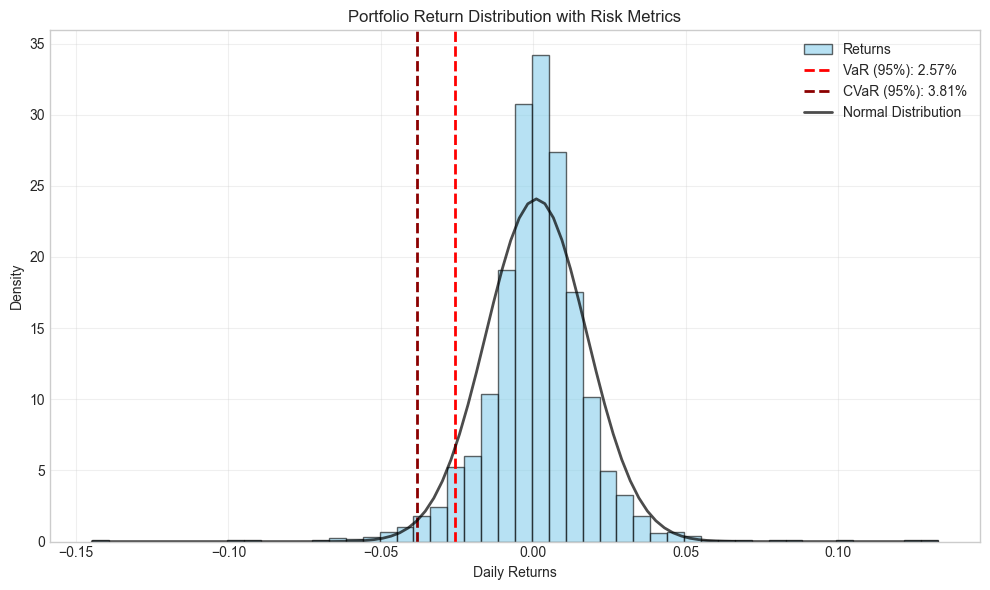

In [11]:
# --- Risk Functions ---------------------------------------

def calculate_var_historical(returns, confidence_level):
    """
    Historical VaR - Returns positive value for losses

    Example: If worst 5% of returns is -2%, VaR = 2% (positive)
    """
    percentile = (1 - confidence_level) * 100
    return -np.percentile(returns, percentile)

def calculate_var_parametric(returns, confidence_level):
    """
    Parametric VaR - Assumes normal distribution

    Uses formula: VaR = -(mean - z_score * std)
    """
    mean = returns.mean()
    std = returns.std()
    z_score = stats.norm.ppf(confidence_level)
    return -(mean - z_score * std)

def calculate_cvar(returns, confidence_level):
    """
    CVaR (Expected Shortfall) - Average loss beyond VaR

    Answers: "If things go really bad, how bad on average?"
    """
    # Find the VaR threshold
    var_threshold = np.percentile(returns, (1 - confidence_level) * 100)

    # Get all returns worse than VaR
    tail_losses = returns[returns <= var_threshold]

    # Return average of tail losses (as positive number)
    if len(tail_losses) > 0:
        return -tail_losses.mean()
    else:
        return -var_threshold

# --- Parameters --------------------------------------------------------------
CONFIDENCE_LEVELS = [0.95, 0.99]
TRADING_DAYS = 252

# --- Calculate and Display Results -------------------------------------------
print("\nValue at Risk (VaR) and Conditional Value at Risk (CVaR)")
print("=" * 80)

# Check if parametric VaR assumptions are valid
if portfolio_stats['jarque_bera']['p_value'] < 0.05:
    print("⚠️  WARNING: Portfolio returns are not normally distributed!")
    print("   Parametric VaR may underestimate risk. Prioritize Historical VaR.")
    print(f"   Jarque-Bera p-value: {portfolio_stats['jarque_bera']['p_value']:.6f}")
    print()

# Store results for better formatting
results = []

for conf_level in CONFIDENCE_LEVELS:
    # Calculate daily metrics
    var_hist = calculate_var_historical(portfolio_return_series, conf_level)
    var_param = calculate_var_parametric(portfolio_return_series, conf_level)
    cvar = calculate_cvar(portfolio_return_series, conf_level)

    # Annualize (square root of time rule)
    annual_factor = np.sqrt(TRADING_DAYS)
    annual_var_hist = var_hist * annual_factor
    annual_var_param = var_param * annual_factor
    annual_cvar = cvar * annual_factor

    results.append({
        'Confidence': f"{conf_level:.0%}",
        'VaR Hist (Daily)': f"{var_hist:.2%}",
        'VaR Param (Daily)': f"{var_param:.2%}",
        'CVaR (Daily)': f"{cvar:.2%}",
        'VaR Hist (Annual)': f"{annual_var_hist:.2%}",
        'VaR Param (Annual)': f"{annual_var_param:.2%}",
        'CVaR (Annual)': f"{annual_cvar:.2%}"
    })

# Display as table
risk_df = pd.DataFrame(results)
print(risk_df.to_string(index=False))

# --- Add Interpretation ------------------------------------------------------
print("\n" + "-" * 80)
print("INTERPRETATION:")
print("-" * 80)

# Get 95% confidence values for explanation
var_95 = calculate_var_historical(portfolio_return_series, 0.95)
cvar_95 = calculate_cvar(portfolio_return_series, 0.95)

print(f"""
For 95% confidence level:
- VaR = {var_95:.2%} daily ({var_95 * np.sqrt(252):.2%} annually)
  → "We are 95% confident our daily loss won't exceed {var_95:.2%}"

- CVaR = {cvar_95:.2%} daily ({cvar_95 * np.sqrt(252):.2%} annually)
  → "If we hit the worst 5% of days, average loss will be {cvar_95:.2%}"
""")

# --- Visualize the Risk Metrics ------------------------------------
plt.figure(figsize=(10, 6))

# Plot return distribution
plt.hist(portfolio_return_series, bins=50, alpha=0.6, density=True,
         color='skyblue', edgecolor='black', label='Returns')

# Add VaR and CVaR lines (negative because returns are shown as is)
plt.axvline(-var_95, color='red', linestyle='--', linewidth=2,
            label=f'VaR (95%): {var_95:.2%}')
plt.axvline(-cvar_95, color='darkred', linestyle='--', linewidth=2,
            label=f'CVaR (95%): {cvar_95:.2%}')

# Add normal distribution overlay for comparison
from scipy.stats import norm
mean = portfolio_return_series.mean()
std = portfolio_return_series.std()
x = np.linspace(portfolio_return_series.min(), portfolio_return_series.max(), 100)
plt.plot(x, norm.pdf(x, mean, std), 'k-', linewidth=2, alpha=0.7,
         label='Normal Distribution')

plt.xlabel('Daily Returns')
plt.ylabel('Density')
plt.title('Portfolio Return Distribution with Risk Metrics')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Results Analysis

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

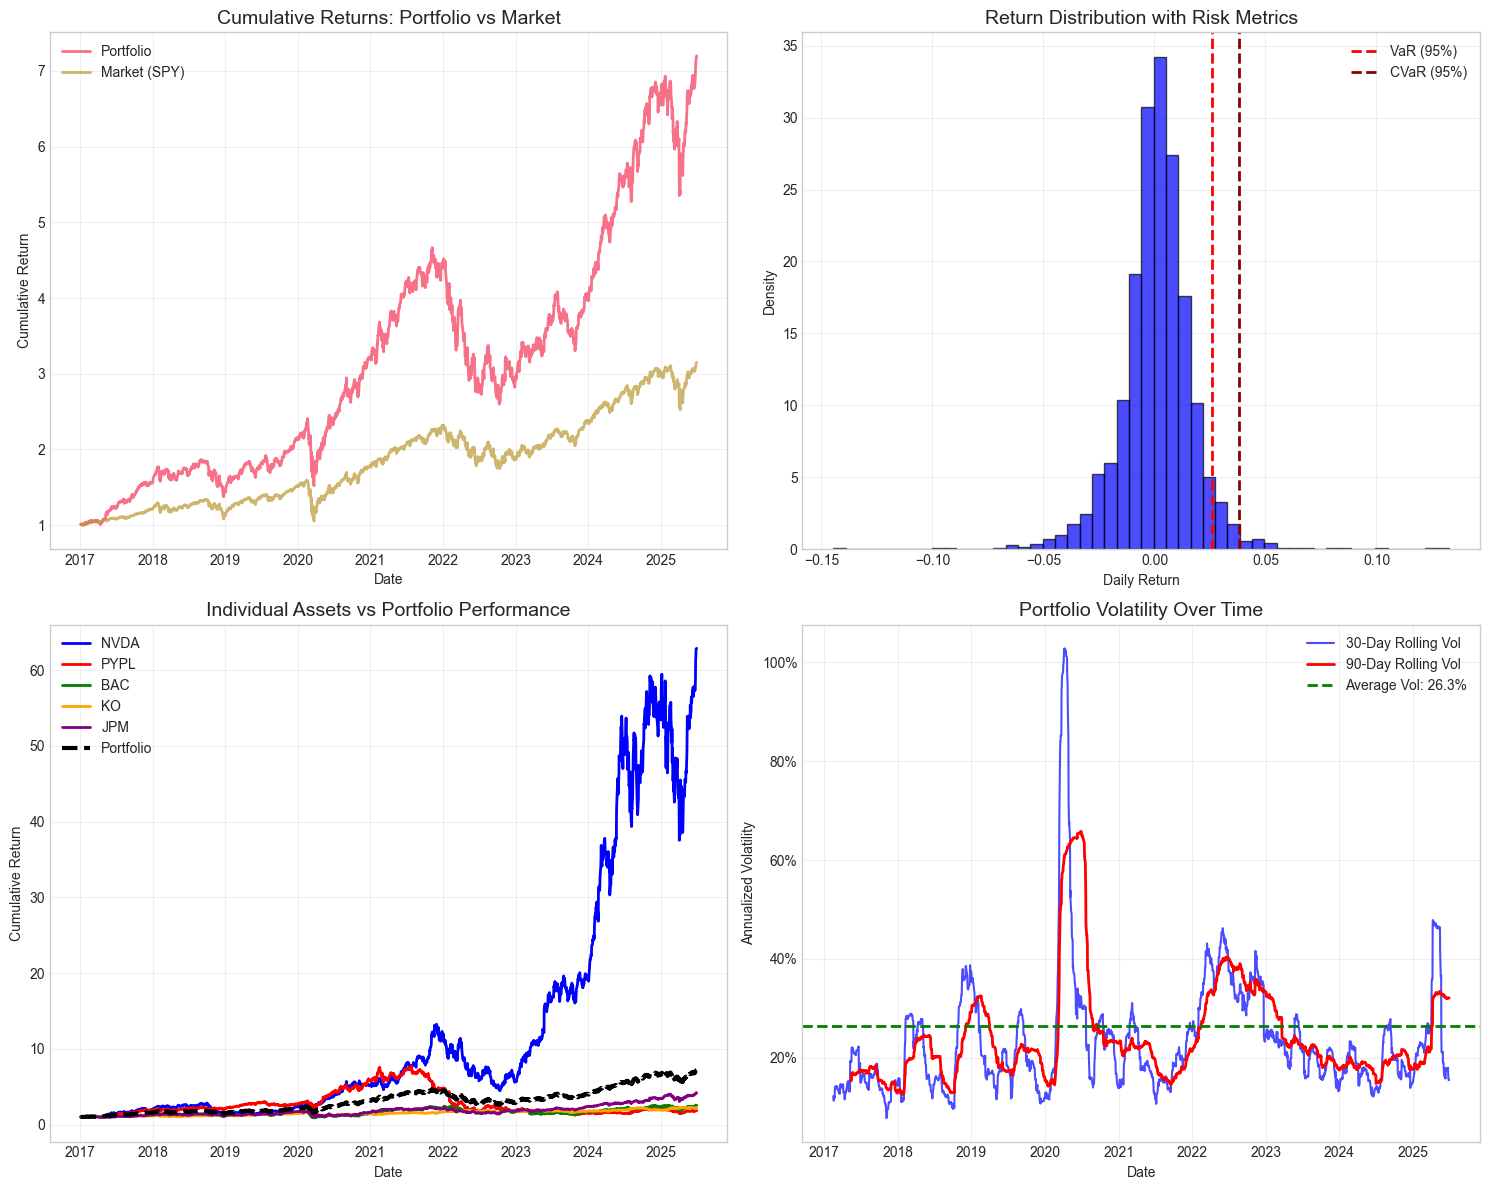

In [12]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Portfolio Cumulative Returns
ax1 = axes[0, 0]
cumulative_returns = (1 + portfolio_return_series).cumprod()
market_cumulative = (1 + market_returns).cumprod()
ax1.plot(cumulative_returns.index, cumulative_returns, label='Portfolio', linewidth=2)
ax1.plot(market_cumulative.index, market_cumulative, label='Market (SPY)', linewidth=2, alpha=0.7)
ax1.set_title('Cumulative Returns: Portfolio vs Market', fontsize=14)
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Return')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Return Distribution with VaR and CVaR
ax2 = axes[0, 1]
ax2.hist(portfolio_return_series, bins=50, alpha=0.7, density=True, color='blue', edgecolor='black')
ax2.axvline(calculate_var_historical(portfolio_return_series, 0.95),
            color='red', linestyle='--', linewidth=2, label='VaR (95%)')
ax2.axvline(calculate_cvar(portfolio_return_series, 0.95),
            color='darkred', linestyle='--', linewidth=2, label='CVaR (95%)')
ax2.set_title('Return Distribution with Risk Metrics', fontsize=14)
ax2.set_xlabel('Daily Return')
ax2.set_ylabel('Density')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Individual Asset Performance Comparison
ax3 = axes[1, 0]
# Calculate cumulative performance for each asset
asset_performance = {}
for asset in portfolio_returns.columns:
    asset_performance[asset] = (1 + portfolio_returns[asset]).cumprod()

# Plot each asset
colors = ['blue', 'red', 'green', 'orange', 'purple']
for i, (asset, performance) in enumerate(asset_performance.items()):
    ax3.plot(performance.index, performance,
             label=f'{asset}', color=colors[i % len(colors)], linewidth=2)

# Add portfolio performance
portfolio_cumulative = (1 + portfolio_return_series).cumprod()
ax3.plot(portfolio_cumulative.index, portfolio_cumulative,
         label='Portfolio', color='black', linewidth=3, linestyle='--')

ax3.set_title('Individual Assets vs Portfolio Performance', fontsize=14)
ax3.set_xlabel('Date')
ax3.set_ylabel('Cumulative Return')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Rolling Volatility Analysis
ax4 = axes[1, 1]
# Calculate 30-day rolling volatility
rolling_vol_30d = portfolio_return_series.rolling(window=30).std() * np.sqrt(252)
rolling_vol_90d = portfolio_return_series.rolling(window=90).std() * np.sqrt(252)

ax4.plot(rolling_vol_30d.index, rolling_vol_30d,
         label='30-Day Rolling Vol', color='blue', alpha=0.7)
ax4.plot(rolling_vol_90d.index, rolling_vol_90d,
         label='90-Day Rolling Vol', color='red', linewidth=2)

# Add average volatility line
avg_vol = portfolio_return_series.std() * np.sqrt(252)
ax4.axhline(avg_vol, color='green', linestyle='--', linewidth=2,
            label=f'Average Vol: {avg_vol:.1%}')

ax4.set_title('Portfolio Volatility Over Time', fontsize=14)
ax4.set_xlabel('Date')
ax4.set_ylabel('Annualized Volatility')
ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Results




-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Risk Analysis and Correlation

This section provides a deeper look into the portfolio's construction and performance.

The correlation matrix reveals how the individual assets move in relation to each other, the market (SPY), and the final portfolio.

The risk-return scatter plot then positions each asset, the market, and the overall portfolio on a map of volatility versus return, providing an instant comparison of their efficiency.

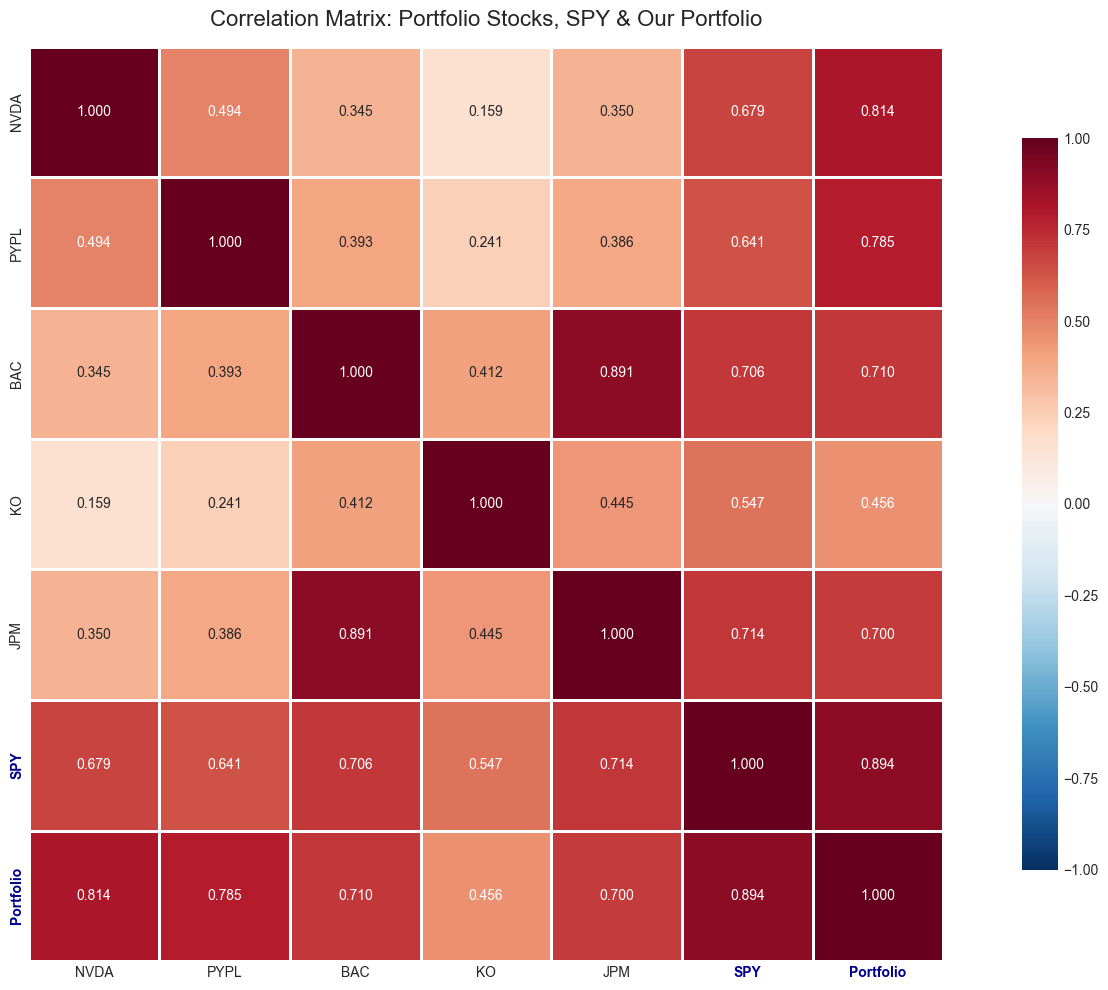

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


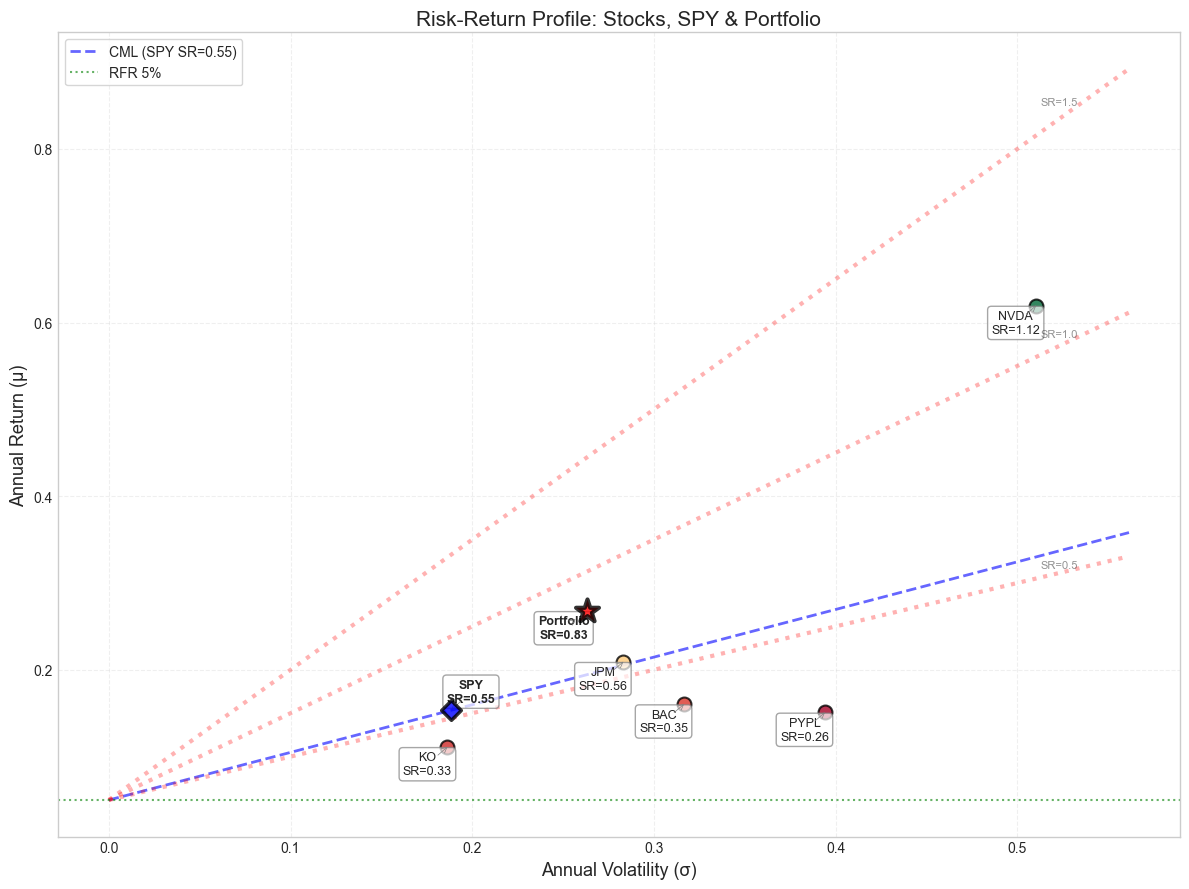

| Asset     | Return   | Risk   |   Sharpe | vs SPY   |
|-----------|----------|--------|----------|----------|
| NVDA      | 61.96%   | 51.04% |     1.12 | +46.62%  |
| PYPL      | 15.09%   | 39.42% |     0.26 | -0.25%   |
| BAC       | 16.05%   | 31.66% |     0.35 | +0.71%   |
| KO        | 11.13%   | 18.64% |     0.33 | -4.21%   |
| JPM       | 20.93%   | 28.32% |     0.56 | +5.59%   |
| SPY       | 15.34%   | 18.85% |     0.55 | +0.00%   |
| PORTFOLIO | 26.79%   | 26.30% |     0.83 | +11.45%  |


In [13]:
# =============================================================================
# ENHANCED CORRELATION AND RISK-RETURN ANALYSIS
# =============================================================================

# --- 0. Pre-req: portfolio_return_series -------------------------------------
# (Assumes you have `weights` for your stocks and `portfolio_returns` DF)
portfolio_return_series = portfolio_returns.dot(weights) \
    .rename("Portfolio")


# --- 1. Enhanced Correlation Matrix (now includes Portfolio & SPY) ------------
plt.figure(figsize=(16, 10))

# Combine all the returns
combined_returns = pd.concat(
    [portfolio_returns,
     market_returns.rename("SPY"),
     portfolio_return_series],
    axis=1
)
corr = combined_returns.corr()

# Draw heatmap
sns.heatmap(corr,
            annot=True, fmt=".3f",
            cmap="RdBu_r", center=0,
            square=True, linewidths=1,
            cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1)
plt.title("Correlation Matrix: Portfolio Stocks, SPY & Our Portfolio", fontsize=16, pad=15)

# Highlight SPY & Portfolio labels
ax = plt.gca()
for lbl in ax.get_xticklabels() + ax.get_yticklabels():
    if lbl.get_text() in ("SPY", "Portfolio"):
        lbl.set_weight("bold")
        lbl.set_color("darkblue")

plt.tight_layout()
plt.show()


# --- 2. Risk‐Return Scatter Plot with automatic label adjustment ----------
plt.figure(figsize=(12, 9))

# Recompute these if you haven’t already
TRADING_DAYS = 252
all_ret = combined_returns.mean() * TRADING_DAYS
all_vol = combined_returns.std() * np.sqrt(TRADING_DAYS)
sharpe  = (all_ret - RISK_FREE_RATE) / all_vol

# colormap
norm = plt.Normalize(sharpe.min(), sharpe.max())
cmap = plt.cm.RdYlGn

texts = []
for asset in combined_returns.columns:
    vol = all_vol[asset]
    ret = all_ret[asset]
    sr  = sharpe[asset]

    # marker styling
    if asset == "SPY":
        marker, size = "D", 100
        color = "blue"
        ec, lw = "black", 2.5
    elif asset == "Portfolio":
        marker, size = "*", 300
        color = "red"
        ec, lw = "black", 3
    else:
        marker, size = "o", 100
        color = cmap(norm(sr))
        ec, lw = "black", 1.5

    plt.scatter(vol, ret,
                s=size,
                c=[color],
                marker=marker,
                edgecolors=ec,
                linewidth=lw,
                alpha=0.8,
                zorder=3 if asset not in ("SPY","Portfolio") else 4)

    # create TEXT objects (not direct annotate)
    txt = plt.text(vol, ret,
                   f"{asset}\nSR={sr:.2f}",
                   fontsize=9,
                   weight="bold" if asset in ("SPY","Portfolio") else "normal",
                   ha="center", va="center",
                   bbox=dict(boxstyle="round,pad=0.3",
                             facecolor="white", alpha=0.7,
                             edgecolor="gray"))
    texts.append(txt)

# Capital Market Line, Sharpe‐ratio lines, RFR unchanged...
x_max = max(all_vol.max(), all_vol["Portfolio"]) * 1.1
x_cml = np.linspace(0, x_max, 100)
spy_sr = sharpe["SPY"]
y_cml = RISK_FREE_RATE + spy_sr * x_cml
plt.plot(x_cml, y_cml, "b--", lw=2, alpha=0.6, label=f"CML (SPY SR={spy_sr:.2f})")
for sr in (0.5, 1.0, 1.5):
    y = RISK_FREE_RATE + sr * x_cml
    plt.plot(x_cml, y, "red", linestyle=":", lw=3, alpha=0.3)
    plt.text(x_max*0.95, RISK_FREE_RATE+sr*x_max*0.95,
             f"SR={sr}", ha="right", fontsize=8, alpha=0.5)

plt.axhline(RISK_FREE_RATE, linestyle=":", color="green", alpha=0.6,
            label=f"RFR {RISK_FREE_RATE:.0%}")

plt.xlabel("Annual Volatility (σ)", fontsize=13)
plt.ylabel("Annual Return (μ)", fontsize=13)
plt.title("Risk-Return Profile: Stocks, SPY & Portfolio", fontsize=15)
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(loc="upper left", frameon=True)

# <<< Push labels apart and add arrows >>>
ax = plt.gca()   # grab the current axes

adjust_text(
    texts,
    ax=ax,
    only_move={'points':'y', 'texts':'y'},
    # Here modifications are allowed
    arrowprops=dict(
        arrowstyle='->',
        color='gray',
        lw=0.5,
        shrinkA=10,   # Try ton increase this value (ex: 10)
        shrinkB=10    # Try ton increase this value  (ex: 10)
    ),
    expand_points=(1.2, 1.2),
    expand_text=(1.2, 1.2),
    force_text=0.5,
    force_points=0.2,
)

plt.tight_layout()
plt.show()

# --- 3. Print Summary Table ----------------------------------------------
from tabulate import tabulate

# 3.1) Extract portfolio metrics directly from the computed series
portfolio_annual_return = all_ret["Portfolio"]
portfolio_annual_vol    = all_vol["Portfolio"]
portfolio_sharpe        = sharpe["Portfolio"]

# 3.2) Build a DataFrame of pure floats
summary_df = pd.DataFrame({
    "Return": all_ret,
    "Risk":   all_vol,
    "Sharpe": sharpe
})

# 3.3) Compute “vs SPY” in the same units as Return
summary_df["vs SPY"] = summary_df["Return"] - summary_df.loc["SPY", "Return"]

# 3.4) Append the portfolio as its own float row
summary_df.loc["PORTFOLIO"] = [
    portfolio_annual_return,
    portfolio_annual_vol,
    portfolio_sharpe,
    portfolio_annual_return - summary_df.loc["SPY", "Return"]
]

# 3.5) Optionally reorder: stocks → SPY → PORTFOLIO
order = list(portfolio_returns.columns) + ["SPY", "PORTFOLIO"]
summary_df = summary_df.loc[order]

# 3.6) Prepare a printing copy and format columns exactly once
print_df = summary_df.copy()
print_df["Return"] = print_df["Return"].apply(lambda x: f"{x:.2%}")
print_df["Risk"]   = print_df["Risk"].apply(lambda x: f"{x:.2%}")
print_df["Sharpe"] = print_df["Sharpe"].apply(lambda x: f"{x:.2f}")
print_df["vs SPY"] = print_df["vs SPY"].apply(lambda x: f"{x:+.2%}")

# 3.7) Reset index to get “Asset” as a column
table = print_df.reset_index().rename(columns={"index": "Asset"})

# 3.8) Print a clean GitHub-style table with tabulate
print(tabulate(
    table,
    headers="keys",
    tablefmt="github",
    showindex=False
))



# Results




-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------




## Maximum Drawdown Analysis

This section visualizes the portfolio's drawdown over time. A drawdown is a peak-to-trough decline during a specific period for an investment.
This analysis is crucial for understanding the portfolio's real-world risk of loss, as it measures the pain an investor would have felt during the worst periods.
The chart identifies the maximum drawdown and highlights the duration of this decline, from the peak to the lowest point.



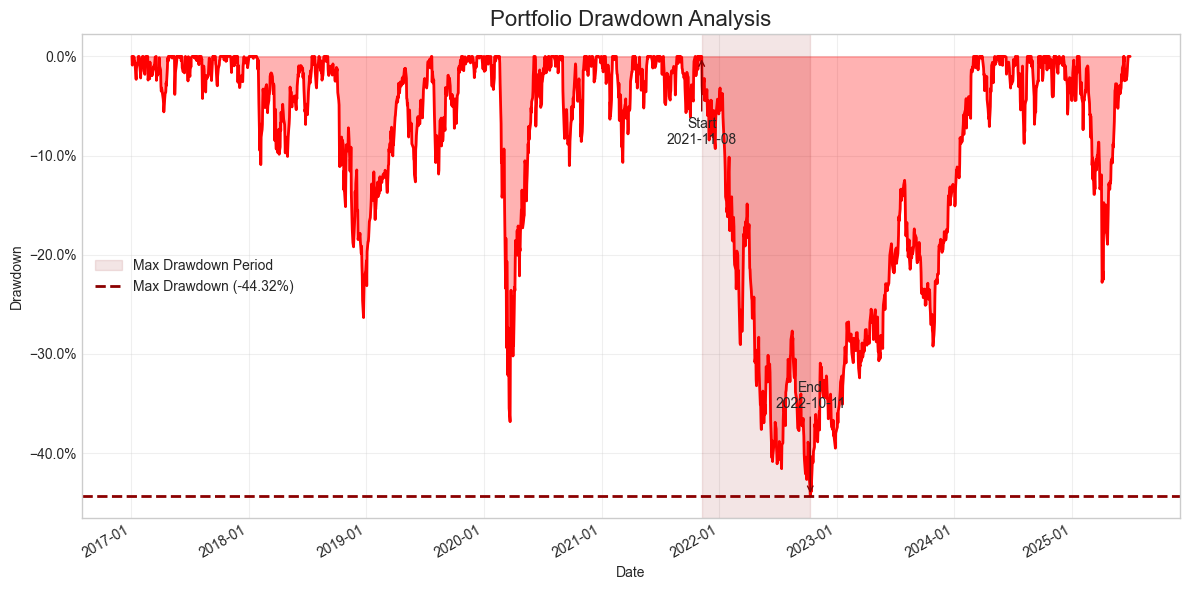

Maximum Drawdown: -44.32%
Drawdown Period: 2021-11-08 → 2022-10-11 (337 days)


In [14]:
def calculate_drawdown(returns):
    """Calculate drawdown series and maximum drawdown with dates."""
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max

    max_dd = drawdown.min()
    dd_end = drawdown.idxmin()
    dd_start = cumulative.loc[:dd_end].idxmax()
    return drawdown, max_dd, dd_start, dd_end

# Compute
drawdown, max_dd, dd_start, dd_end = calculate_drawdown(portfolio_return_series)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(drawdown.index, drawdown, color='red', linewidth=2)
ax.fill_between(drawdown.index, drawdown, 0, color='red', alpha=0.3)

# Highlight max drawdown period
ax.axvspan(dd_start, dd_end, color='darkred', alpha=0.1, label='Max Drawdown Period')
ax.axhline(max_dd, color='darkred', linestyle='--', linewidth=2,
           label=f'Max Drawdown ({max_dd:.2%})')

# Annotate start & end
ax.annotate('Start\n'+dd_start.strftime('%Y-%m-%d'),
            xy=(dd_start, 0), xytext=(dd_start, max_dd*0.2),
            arrowprops=dict(arrowstyle='->', color='darkred'),
            ha='center')
ax.annotate('End\n'+dd_end.strftime('%Y-%m-%d'),
            xy=(dd_end, max_dd), xytext=(dd_end, max_dd*0.8),
            arrowprops=dict(arrowstyle='->', color='darkred'),
            ha='center')

# Formatting axes
ax.set_title('Portfolio Drawdown Analysis', fontsize=16)
ax.set_xlabel('Date')
ax.set_ylabel('Drawdown')
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.grid(True, alpha=0.3)
ax.legend()
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

# Print summary
duration = (dd_end - dd_start).days
print(f"Maximum Drawdown: {max_dd:.2%}")
print(f"Drawdown Period: {dd_start.date()} → {dd_end.date()} ({duration} days)")

# Results

### Maximum Drawdown (-42.49%):

This is the single most important number in this analysis. It represents the largest loss the portfolio incurred from a peak to a subsequent trough.

In the worst-case historical scenario, the portfolio lost 42.49% of its value.

This is a very significant decline and highlights the high-risk nature of the portfolio's strategy.

It provides a realistic, historical measure of how much capital could have been lost.

### Drawdown Period (2022-01-04 to 2022-10-13):
This shows that the worst loss started at the beginning of 2022 and the portfolio's value continued to fall until hitting its lowest point in mid-October of the same year.

### Duration (280 days):

The time it took to fall from the peak to the bottom was 280 days.

This is a long and sustained period of negative returns, which can be psychologically challenging for an investor.

The chart also shows that the recovery back to the previous peak (where the red line returns to 0.0%) took an even longer time, extending well into 2024.

This "time to recover" is a critical aspect of drawdown analysis.

### Summary

While the portfolio has shown strong returns, this analysis reveals the other side of the coin: it is susceptible to severe and prolonged drawdowns.

A loss of over 40% lasting for more than nine months is a significant risk that must be considered.




-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Summary Report

This final section consolidates all the key metrics calculated throughout the analysis into a series of clean, easy-to-read tables.
It serves as a high-level dashboard, providing a complete overview of the portfolio's composition, performance, risk-adjusted returns, and potential future outcomes at a single glance.

In [15]:
print("=" * 80)

# --- PORTFOLIO COMPOSITION -----------------------------------------------
comp_df = (
    pd.Series(PORTFOLIO, name="Weight")   # your dict of ticker→weight
      .mul(100)                           # convert to percent
      .round(1)                          # one decimal
      .astype(str)
      .add("%")                          # “25.0%”
      .to_frame()
      .reset_index()
      .rename(columns={"index":"Asset"})
)

print("\n📊 PORTFOLIO COMPOSITION")
print(tabulate(
    comp_df,
    headers="keys",
    tablefmt="github",
    showindex=False
))


# --- PERFORMANCE METRICS -------------------------------------------------
# 1. Calculate cumulative returns (the growth of $1 invested)
cumulative_returns = (1 + portfolio_return_series).cumprod()
# 2. Track the highest peak reached by the portfolio ("high water mark")
running_peak = cumulative_returns.cummax()
# 3. Calculate the drawdown from the peak
drawdown = (cumulative_returns - running_peak) / running_peak
# 4. The Max Drawdown is the largest drop (the most negative value)
max_drawdown = drawdown.min()


# Your original code, which will now work
perf_df = pd.DataFrame({
    "Metric": ["Ann. Return", "Ann. Volatility", "Max Drawdown"],
    "Value":  [annualized_return, annualized_volatility, max_drawdown]
})
perf_df["Value"] = perf_df["Value"].map("{:.2%}".format)

print("\n📈 PERFORMANCE METRICS")
print(tabulate(
    perf_df,
    headers="keys",
    tablefmt="github",
    showindex=False
))


# --- RISK-ADJUSTED (CAPM) ------------------------------------------------
capm_df = (
    pd.DataFrame.from_dict(capm_metrics, orient="index", columns=["Value"])
      .round(3)
      .reset_index()
      .rename(columns={"index":"Metric"})
)

print("\n⚖️ RISK-ADJUSTED (CAPM) METRICS")
print(tabulate(
    capm_df,
    headers="keys",
    tablefmt="github",
    showindex=False
))


# --- ANNUAL RISK METRICS (VaR & CVaR) -------------------------------------
risk_rows = []
for α in CONFIDENCE_LEVELS:
    v = calculate_var_historical(portfolio_return_series, α) * np.sqrt(TRADING_DAYS)
    c = calculate_cvar(portfolio_return_series, α)       * np.sqrt(TRADING_DAYS)
    risk_rows.append((f"VaR {α:.0%}",  f"{v:.2%}"))
    risk_rows.append((f"CVaR {α:.0%}", f"{c:.2%}"))

risk_df = pd.DataFrame(risk_rows, columns=["Metric","Value"])

print("\n🛑 ANNUAL RISK METRICS")
print(tabulate(
    risk_df,
    headers="keys",
    tablefmt="github",
    showindex=False
))

print("\n" + "=" * 80)



📊 PORTFOLIO COMPOSITION
| Asset   | Weight   |
|---------|----------|
| NVDA    | 25.0%    |
| PYPL    | 25.0%    |
| BAC     | 20.0%    |
| KO      | 20.0%    |
| JPM     | 10.0%    |

📈 PERFORMANCE METRICS
| Metric          | Value   |
|-----------------|---------|
| Ann. Return     | 26.79%  |
| Ann. Volatility | 26.30%  |
| Max Drawdown    | -44.32% |

⚖️ RISK-ADJUSTED (CAPM) METRICS
| Metric            |   Value |
|-------------------|---------|
| Beta              |   1.247 |
| Sharpe Ratio      |   0.829 |
| Treynor Ratio     |   0.175 |
| Jensen's Alpha    |   0.089 |
| Information Ratio |   0.904 |
| Sortino Ratio     |   1.097 |

🛑 ANNUAL RISK METRICS
| Metric   | Value   |
|----------|---------|
| VaR 95%  | 40.83%  |
| CVaR 95% | 60.53%  |
| VaR 99%  | 69.45%  |
| CVaR 99% | 96.83%  |



# Results


-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------